# Star Trek The Next Generation - Downloading and Cleaning the Transcripts

Here you find a IPython notbook to download and clean the STNG transcripts from http://www.chakoteya.net/NextGen/ 

The results are saved into a pandas DataFrame, which I reuse in 
* **startrekng-episodes-analysis_02.ipynb** - where I performed some statistical analysis on the data (who speaks how many lines, or in how many episodes does a character appear)
* **startrekng-episodes-analysis_03.ipynb** - where I performed some text analysis to predict which lines are probably said by which character

Thanks a lot to Chrissie from chakoteya.net for transcribing all the STNG episodes! I hope you like what I get out of the your data!



In [1]:
import re
from bs4 import BeautifulSoup
from urllib import urlopen
import urlparse

base = "http://www.chakoteya.net/NextGen/episodes.htm"
html=urlopen(base)

soup = BeautifulSoup(html,"html.parser")

episodelinks=[]
htmllinks = soup.findAll("a")
for l in htmllinks:
    if l.has_attr("href"):
        href = l["href"]
        if re.match(r"\d+.htm", href): # link looks like: "123.htm"
            episodelinks.append(urlparse.urljoin(base,href) )

episodelinks, len(episodelinks) 
# should be 176 (actually it is 178 episodes, but chakoteya has put episodes 1+2 in one file as well as episode 177+178 )


([u'http://www.chakoteya.net/NextGen/101.htm',
  u'http://www.chakoteya.net/NextGen/103.htm',
  u'http://www.chakoteya.net/NextGen/104.htm',
  u'http://www.chakoteya.net/NextGen/107.htm',
  u'http://www.chakoteya.net/NextGen/106.htm',
  u'http://www.chakoteya.net/NextGen/108.htm',
  u'http://www.chakoteya.net/NextGen/109.htm',
  u'http://www.chakoteya.net/NextGen/110.htm',
  u'http://www.chakoteya.net/NextGen/111.htm',
  u'http://www.chakoteya.net/NextGen/105.htm',
  u'http://www.chakoteya.net/NextGen/113.htm',
  u'http://www.chakoteya.net/NextGen/114.htm',
  u'http://www.chakoteya.net/NextGen/115.htm',
  u'http://www.chakoteya.net/NextGen/116.htm',
  u'http://www.chakoteya.net/NextGen/112.htm',
  u'http://www.chakoteya.net/NextGen/118.htm',
  u'http://www.chakoteya.net/NextGen/117.htm',
  u'http://www.chakoteya.net/NextGen/119.htm',
  u'http://www.chakoteya.net/NextGen/120.htm',
  u'http://www.chakoteya.net/NextGen/121.htm',
  u'http://www.chakoteya.net/NextGen/123.htm',
  u'http://ww

# Download of the Transcripts


In [5]:
def getFileName(keyCnt):
    return "{0:0>4}.txt".format(keyCnt)

idx = 0
for idx, url in enumerate(episodelinks): #[-2:]): # nur die ersten 2
    
    print "DO NOT MAKE IT SO - I already have the files :-)"
    break; # remove break  to actually download files
    
    
    #if idx == 0:
    #    continue
    print idx, url
    html=urlopen(url).read()
    soup=BeautifulSoup(html)
    #allP=soup.findAll('p')
    allP=soup.find_all(text=True)
    txts = []
    for pidx, p in enumerate(allP):
        t = p.replace('\n', ' ').replace('\r', '').strip()
        txts.append(t)
        #print pidx, t
        
    filename = getFileName(idx)
    print filename
    episode = open(filename, 'w')
    episode.write(BeautifulSoup("\n".join(txts)).get_text().encode('utf-8').strip())
    episode.close()
    
    

DO NOT MAKE IT SO - I already have the files :-)


# Loading the Text-Files in a pandas DataFrame

I played around with the regular expression to get the speaking characters in one array and the spoken lines in another. 
After reviewing the files I state the assumption that there has to be a colon in a (file-)line, when a character speaks its line. Normally it looks like this:

*CHARACTER NAME : What ever he has to say. No matter how many words we say, we stay in one line, what is pretty nice.*

I have to make some assumption like this, because there are (file-)lines, with meta-information only.
There are only a few cases, where the spoken line of a character starts in the next line.

I analyze the lines without a colon in `allOtherLinesDf` to be more thorough (see below), but it appears there are not so many spoken lines left, which I did not match with my assumption (around 130). So I left them out at the end, as a todo for some day later...

But nevertheless, have a look at my analysis:



In [164]:
import pandas as pd
import re
from bs4 import BeautifulSoup
from urllib import urlopen
import urlparse
import os
from fnmatch import fnmatch

# list only .txt files
episodes = []
for filename in os.listdir('.'):
    if fnmatch(filename, "*.txt"):
        episodes.append(filename)


characterLines = []
allOtherLines = []
eCnt = 0  # counts the episode files
lCnt = 0  # counts all lines in a file
lColCnt = 0 # conts all lines with : appearing

for eFilename in episodes:
    
    # per file we count an episode - we start with 1
    eCnt += 1
    
    episodeFile = open(eFilename, 'r')
    eScript = episodeFile.readlines()
    eName = None
    elCnt = 0 # counts all file lines in one episode file
    eclCnt = 0 # counts all lines of characters per episode
    for line in eScript:
        lCnt += 1#
        elCnt += 1
        # this line is actually in every file and holds the episodes title = eName:
        eNameGroups  = re.match("The Next Generation Transcripts - (.+)", line) 
        if eNameGroups:
            eName = eNameGroups.group(1)
            
        
        # this regular expression gives us all lines like "Name Without A Colon : the line of the character
        groups  = re.match("([^:]+):(.+)", line) 
        groupsColon  = re.match(".*", line)
        if (groupsColon and not groups):
            lColCnt += 1
            allOtherLines.append((groupsColon.group(0), eName, eCnt, elCnt))
            
        
        # groups 
        # group 1 : the character's name
        # group 2 : his line / the spoken words
        if groups:
            eclCnt += 1
            characterLines.append((groups.group(1),groups.group(2),eName,eCnt,eclCnt))
            
        
print "number of lines in all files: ", lCnt, " number of lines without a colon: lColCnt"
cLinesDf = pd.DataFrame(characterLines, columns=["character","line","epsName","epsIdx", "epsLineIdx"])
cLinesDf.set_index("character",inplace=True)
print "numer of spoken lines: ", cLinesDf.shape[0]
cLinesDf.sort_index().epsIdx.unique().size
allOtherLinesDf = pd.DataFrame(allOtherLines, columns=["line","epsName","epsIdx", "epsFileLineIdx"])

number of lines in all files:  100378  number of lines without a colon: lColCnt
numer of spoken lines:  63833


At first we see, that we have around **63833 spoken lines** in stng. That seems to be a plausible result, because we have overall line-count of 100379 with some empty lines.


# Cleaning the Data -  Analyzing the not-colon-lines

At first I wanted to get a little overview of the sorted .unique() lines, which do not have a colon inside

In [165]:
thelines = sorted(allOtherLinesDf["line"].unique().tolist())
print len(thelines)
thelines

7448


['',
 "'. It's not a promising beginning.",
 "'How relaxing the sound of the waves is,' you said.",
 "'and thick and fast they came at last, and more, and more, and more'",
 '(',
 '((Everyone gets two hole cards and one face up)',
 "((K'Ehleyr has changed into a red leather catsuit)",
 "((Riker O'Brien and a guard are trapped behind a forcefield. Riker pulls his phaser)",
 "((Sovak presses something into Picard's back and pushes them to a quiet area)",
 '(A Borg beams onto the Bridge. Worf shoots it. A second one appears. This time the phaser bounces off a shield)',
 '(A Borg kills Corelki, Worf kills him. Another Borg grabs Data by the throat and Data does likewise, throttling him)',
 '(A Borg walks past them, taking no notice)',
 '(A Ferengi beams in)',
 "(A Klingon mug, with steam coming off it. The top Danilo's head does a somersault)",
 '(A Klingon woman is kneeling at his feet. She gets up, tries to swipe at Tasha, and gets knocked down by Worf)',
 '(A Mexican Mariachi band appea

looks like a lot are just screenplay instructions in brakets (in some cases the braket is missing at the start/end)

In [166]:
print len(allOtherLinesDf[( (allOtherLinesDf["line"].str.endswith(")")) &
                            (allOtherLinesDf["line"].str.startswith("(")))]["line"].unique())  # brakets at start and end

# what about the lines with only one braket?
print len(allOtherLinesDf[(~(allOtherLinesDf["line"].str.endswith(")")) &
                             (allOtherLinesDf["line"].str.startswith("(")))]["line"].unique()) # missing braket at end
print len(allOtherLinesDf[( (allOtherLinesDf["line"].str.endswith(")")) &
                            ~(allOtherLinesDf["line"].str.startswith("(")))]["line"].unique()) # missing braket at start

# ok, let's work with these:
print len(allOtherLinesDf[(~(allOtherLinesDf["line"].str.endswith(")")) &
                            ~(allOtherLinesDf["line"].str.startswith("(")))]["line"].unique()) # all lines without brakets at start/end

5839
27
23
1559


now I tried to push down even the left 1559 of all the lines which are obviously not spoken lines.

1. lines with round brakets - that was the biggest part (more then 6000 of 7449 are out)
2. all the log entries (you could argue there are spoken by characters. But it's not spoken interacting with other characters, so I put it on my todo list) - around 450 lines
3. meta data (142 lines)
4. episode names sometimes appear again (160)
5. "The Next Generation Transcripts" - appears 176 times (every file)
6. and square brakets (setting names) and technical meta data (620 lines)

leaves us with only 132 of first 7449 possibly spoken lines


In [167]:
otherLines = sorted(allOtherLinesDf
                    [
                       ~(allOtherLinesDf["line"].str.endswith(")")) & 
                       ~(allOtherLinesDf["line"].str.startswith("(")) &
                       ~(allOtherLinesDf["line"].str.startswith("Captain's Log")) & # get rid of the logs
                       ~(allOtherLinesDf["line"].str.startswith("Captain's log")) & # ok also of the lower case ones
                       ~(allOtherLinesDf["line"].str.startswith("Captain's lot")) & # ah, I missed one misspelling
                       ~(allOtherLinesDf["line"].str.startswith("Captain's personal log")) & # oha, personal logs - get rid of them to
                       ~(allOtherLinesDf["line"].str.startswith("First Officer's log")) & # you also have one? ok you are out too
                       ~(allOtherLinesDf["line"].str.startswith("First officer's log")) & # also in lower case... grr
                       ~(allOtherLinesDf["line"].str.startswith("Acting Captain's log")) & # a really?
                       ~(allOtherLinesDf["line"].str.startswith("Chief Medical Officer's log")) & # and you too ... ok, ok
                       ~(allOtherLinesDf["line"].str.contains(" log ")) & # ok, get rid of all the logs..  hm better with space to get not too much (only 40 or so)
                       ~(allOtherLinesDf["line"].str.contains(" log,")) & # ok, also with comma
                       ~(allOtherLinesDf["line"].str.contains(" Log ")) & # AAND upper case -(that was ovious)
                       ~(allOtherLinesDf["line"].str.contains(" Log,")) & # directly added this (I'm learning, you know...)
                       ~(allOtherLinesDf["line"].str.contains("copyright")) & # ok this is meta info 
                       ~(allOtherLinesDf["line"].str.contains("Copyright")) & # also in upper case
                       ~(allOtherLinesDf["line"].str.contains("CBS")) &   # no need
                       ~(allOtherLinesDf["line"].str.startswith("Star Trek")) &  # yeah ok - metainfo again
                       ~(allOtherLinesDf["line"].str.startswith("Last time on Star Trek")) &   # and again
                       ~(allOtherLinesDf["line"].str.startswith("To Be Continued")) & # and again
                       ~(allOtherLinesDf["line"].str.startswith("And now the conclusion")) & # and again (I had to look it up in the files but it is)
                       ~(allOtherLinesDf["line"].str.startswith("And now, the conclusion")) & # and somtimes with a comma
                       ~(allOtherLinesDf["line"].str.startswith("Stardate")) & # yeah - out
                       ~(allOtherLinesDf["line"].isin(cLinesDf["epsName"].unique())) & # sometimes there is the episode-name of the file again
                       ~(allOtherLinesDf["line"].str.startswith("11001001")) & # sometimes it just starts with it ... there are more but I don't know how to make a "isin contains" yet - (on todo list)
                       ~(allOtherLinesDf["line"].str.startswith("The Next Generation Transcripts -")) & # metainfo...
                       ~(allOtherLinesDf["line"].str.startswith("[")) & # more brakets...
                       ~(allOtherLinesDf["line"].str.startswith("{")) & # and more
                       ~(allOtherLinesDf["line"].str.startswith("]")) & # and even more
                       ~(allOtherLinesDf["line"].str.endswith("]")) & # and more
                       ~(allOtherLinesDf["line"].str.len() <= 1)  & # ok - that is to short
                       ~(allOtherLinesDf["line"].str.startswith("HTML"))  & # na ... technical metainfo
                       ~(allOtherLinesDf["line"].str.startswith("trace"))  # na ... technical metainfo
                    ] 
                    ["line"].unique().tolist())
print len(otherLines), "of ", len(thelines)
otherLines

131 of  7448


["'. It's not a promising beginning.",
 "'How relaxing the sound of the waves is,' you said.",
 "'and thick and fast they came at last, and more, and more, and more'",
 ') He spent the day in a tavern consuming large quantities of gin with his killer, who followed him to this spot and waited over there until the victim slipped into a drunken stupor. Then, out of fear, motivated only by self-protection, strangled him. There is your killer, Inspector.',
 ') Seven, six',
 ', or',
 ', which was about the size of a four story building, really thought the Enterprise was its mother.',
 '. Increase torchlight by twenty percent.',
 '. Oh, now there is a planet. Everything a man wants right at his fingertips. Of course, on the first visit, I got into a wee bit of trouble.',
 '. You never heard anyone whine and complain so much about quarters as she did.',
 'A Matter of Honour - Pagh Bridge',
 'A direct hit, sir. The ship is destroyed.',
 'A singular development of cat communications',
 'A tail i

In [168]:
# try some:
sorted(allOtherLinesDf[(allOtherLinesDf["line"].str.startswith("[")) |
                       (allOtherLinesDf["line"].str.startswith("{")) |
                       (allOtherLinesDf["line"].str.startswith("]")) |
                       (allOtherLinesDf["line"].str.endswith("]"))]["line"].unique().tolist())

['Deadwood street]',
 'Environmental Maintenance Laboratory]',
 'Guest Quarters]',
 'Holodeck]',
 'Observation lounge]',
 'Outside Holodeck]',
 'Phaser range]',
 "Rashella's room]",
 'Ready Room]',
 'Transporter Room]',
 'Transporter room]',
 '[',
 '[1701-C Bridge]',
 '[1701C Bridge]',
 '[1701D Bridge]',
 '[221B Baker Street]',
 '[221b Baker Street]',
 '[Academy gardens]',
 '[Academy hearing room]',
 "[Admiral's Quarters]",
 '[Airlock]',
 '[Aldean corridor]',
 "[Alexana's office]",
 "[Alexander's bedroom]",
 "[Alexander's room]",
 '[Alien bar]',
 '[Alien lab]',
 '[Alien vessel]',
 "[Alkar's quarters]",
 '[Alley]',
 '[Alleyway]',
 "[Amanda's quarters]",
 '[Angosian Senate]',
 '[Ante room]',
 '[Antican quarters]',
 "[Aquiel's quarters]",
 "[Aquiel's shuttlecraft]",
 '[Arboretum]',
 "[Ard'rian's home]",
 '[Arkaria base]',
 '[Art class]',
 "[Artist's Unit]",
 '[Assembly hall]',
 '[Aster home]',
 '[Asylum Corridor]',
 '[Asylum cell]',
 '[Asylum common area]',
 '[Athenaeum]',
 '[Auxiliary co

there could be duplicates (because we worked with unique above) so let's compare it with the lines in the `allOtherLinesDf` again via `isin()`, but we still find only 131 lines.


In [169]:
restOtherLinesDf = allOtherLinesDf[allOtherLinesDf["line"].isin(otherLines)].sort("line")
print restOtherLinesDf.shape[0]
restOtherLinesDf

131


,line,epsName,epsIdx,epsFileLineIdx
8289,'. It's not a promising beginning.,The Royale,37,550
27400,"'How relaxing the sound of the waves is,' you ...",Schisms,130,57
33672,"'and thick and fast they came at last, and mor...",Parallels,162,424
6337,) He spent the day in a tavern consuming large...,"Elementary, Dear Data",28,240
15656,") Seven, six",Menage a Troi,71,519
5879,", or",The Child,26,148
27354,", which was about the size of a four story bui...",Relics,129,507
35686,. Increase torchlight by twenty percent.,Emergence,174,36
27224,". Oh, now there is a planet. Everything a man ...",Relics,129,158
27222,. You never heard anyone whine and complain so...,Relics,129,154


Then I tried to group it by episode, to see how the lines distributes.
Looks like it is mostly 1 or 2 lines per episode but 130="Schisms" and 47="Shades of Gray" stand out:


In [170]:
pd.set_option("display.max_row",500)
allOtherLinesDf[allOtherLinesDf["line"].isin(otherLines)].groupby("epsIdx").size().order(ascending=False)

epsIdx
130    23
47     13
129     8
8       6
37      4
71      4
26      3
57      2
110     2
33      2
120     2
60      2
122     2
28      2
89      2
93      2
174     2
13      2
151     2
162     2
55      2
50      1
52      1
53      1
51      1
176     1
42      1
38      1
35      1
30      1
27      1
20      1
17      1
14      1
5       1
2       1
31      1
74      1
61      1
125     1
163     1
152     1
150     1
141     1
140     1
137     1
135     1
133     1
131     1
126     1
121     1
62      1
115     1
112     1
111     1
105     1
98      1
85      1
78      1
76      1
69      1
68      1
1       1
dtype: int64

### 130=Schisms' 23:
In episode 130 DATA gives a poetry reading (in which RIKER falls asleep apparently) 
Every poem's verse got a naturally in a separate file-line.
That's fair, so I kindly accept that (the poem wouldn't help much to recognize DATAs lines anyway...)
### 47=Shades of Gray's 13:
Maybe it comes naturally with a episode name like this to "hurt" an analyzer. So I looked the file up:

Apparently a lot of the setting-names where written like this:
```
[
Encounter at Farpoint- Holodeck
]
```
That's why it was not filtered by the braket-filtering above.

### 129=Relics' 8
Here are accutally really some spoken lines out of there place. There are line breaks, where they are not expected. 





### Summary of analyzing non-colon lines

From the 131 non-colon lines some are indeed spoken lines, where a colon is missing or where a line break distrubs the assignment to a character-name.

But in comparison to the  **63833 spoken lines** we already discovered, the 132 missing lines will not have a big impact in our statistical analysis, so I leave them out for now (later todo again :-)

last point - let's see, if we miss some BIG text (via line length)

(95, 4)


(23, 5)

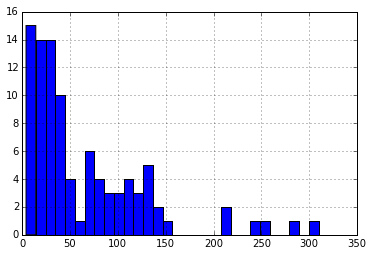

In [171]:
%matplotlib inline
restOfRest = restOtherLinesDf[ ~(restOtherLinesDf["epsIdx"].isin([130,47]))].copy()
print restOfRest.shape # the rest of the lines without "Schisms" and "Shades of Gray"
restOfRest["lineLength"] = restOfRest["line"].apply(lambda x: len(x))
restOfRest.sort("lineLength", ascending=False)["lineLength"].hist(bins=30)
restOfRest[restOfRest["lineLength"] >=  100].shape # even less lines are longer then 100 chars


# The spoken lines 
Let's look at our 63833  discovered spoken lines we already discovered:

In [172]:
pd.set_option("display.max_rows",50)
cLinesDf

,line,epsName,epsIdx,epsLineIdx
character,,,,
Stardate,41153.7,Encounter at Farpoint,1,1
Original Airdate,"28 Sep, 1987",Encounter at Farpoint,1,2
PICARD,"You will agree, Data, that Starfleet's orders...",Encounter at Farpoint,1,3
DATA,Difficult? Simply solve the mystery of Farpoi...,Encounter at Farpoint,1,4
PICARD,As simple as that.,Encounter at Farpoint,1,5
TROI,Farpoint Station. Even the name sounds myster...,Encounter at Farpoint,1,6
PICARD,"It's hardly simple, Data, to negotiate a frie...",Encounter at Farpoint,1,7
DATA,Inquiry. The word snoop?,Encounter at Farpoint,1,8
PICARD,"Data, how can you be programmed as a virtual ...",Encounter at Farpoint,1,9


in this fast printout we only see the 50 rows and it looks like we only have 2 episodes in the DataFrame.
lets see:

In [173]:
epsNames = cLinesDf["epsName"].unique()
print len(epsNames)
sorted(epsNames )

175


[None,
 '11001001',
 'A Fistful of Datas',
 'A Matter of Honour',
 'A Matter of Perspective',
 'A Matter of Time',
 'All Good Things',
 'Allegiance',
 'Angel One',
 'Aquiel',
 'Attached',
 'Birthright part 1',
 'Birthright part 2',
 'Bloodlines',
 'Booby Trap',
 'Brothers',
 "Captain's Holiday",
 'Cause and Effect',
 'Chain of Command, Part 2',
 'Chain of Command, part 1',
 'Clues',
 'Code Of Honour',
 'Coming Of Age',
 'Conspiracy',
 'Contagion',
 'Conundrum',
 'Cost of Living',
 'Dark Page',
 'Darmok',
 "Data's Day",
 'Datalore',
 'Deja Q',
 'Descent part 1',
 'Descent part 2',
 "Devil's Due",
 'Disaster',
 'Elementary, Dear Data',
 'Emergence',
 'Encounter at Farpoint',
 'Ensign Ro',
 'Ethics',
 'Evolution',
 'Eye Of The Beholder',
 'Face of the Enemy',
 'Family',
 'Final Mission',
 'First Contact',
 'Firstborn',
 'Force of Nature',
 'Frame of Mind',
 'Future Imperfect',
 "Galaxy's Child",
 'Gambit part 1',
 'Gambit part 2',
 'Genesis',
 'Half A Life',
 'Haven',
 'Heart Of Glory',
 

wait . ..175? but we do have 176 episode indexes. 

Something is wrong...
My first idea was, that somehow a episode name is used twice? (due to my analyzing error of course)


In [174]:
epsIdx = cLinesDf["epsIdx"]
print len(epsIdx)
epsIdx 

63833


character
Stardate              1
Original Airdate      1
PICARD                1
DATA                  1
PICARD                1
TROI                  1
PICARD                1
DATA                  1
PICARD                1
DATA                  1
PICARD                1
DATA                  1
PICARD                1
DATA                  1
TROI                  1
TORRES                1
DATA                  1
TROI                  1
PICARD                1
WORF                  1
PICARD                1
TORRES                1
Q                     1
PICARD                1
Q                     1
                   ... 
WORF                176
TROI                176
PICARD              176
CRUSHER             176
RIKER               176
LAFORGE             176
RIKER               176
CRUSHER             176
LAFORGE             176
DATA                176
RIKER               176
WORF                176
RIKER               176
TROI                176
RIKER               176
TROI  

but I can not find a epsName with two indexes:

In [175]:
eps = cLinesDf.groupby(["epsName"])["epsIdx"].unique().tolist()
print "no double eps found...", [x for x in eps if len(x) > 1] 

# comment: this works like charm if you really have an array of length 2 in another array:
# [x for x in [[1,2],[3],[4,5],[None, None, None]] if len(x) > 1]

no double eps found... []


ok - the solution is another one - apparently there are TWO `"None"` epsName in the list (you might have seen it in the output above), which are not taken into account by `"groupby("epsName")"`!

I did not know that...
(hint for myself: always look for None values to get the data right...)


In [176]:
cLinesDf[cLinesDf["epsName"].isnull()]["epsIdx"].unique()

array([52, 93], dtype=int64)

in 52 and in 93 the regular expression of my analyzing loop above did not work.

```
    eNameGroups  = re.match("The Next Generation Transcripts - (.+)", line) 
```
was to restrictive, because in these two episodes it looks like this:
* 52: "The Next Generation Transcripts -The Bonding"
* 93: "The Next Generation Transcripts -Qpid"

I expected one whitespace to much.
Nevertheless I leave this mistake as an reminder in this script and change the epsName's manually:



In [177]:
cLinesDf.reset_index(inplace=True)
cLinesDf.set_index("epsIdx", inplace=True) # setting the index, for easier access

cLinesDf.loc[52,"epsName"] = "The Bonding" # have to do it with loc, because otherwise we work on a copy
cLinesDf.loc[93,"epsName"] = "Qpid"

cLinesDf.reset_index(inplace=True)
cLinesDf.set_index("character", inplace=True) # back to the original index

looks about right:

In [178]:
print cLinesDf[cLinesDf["epsIdx"] == 52]["epsName"].size, cLinesDf[cLinesDf["epsIdx"] == 93]["epsName"].size
print cLinesDf[cLinesDf["epsName"] == "The Bonding"]["epsName"].size, cLinesDf[cLinesDf["epsName"] == "Qpid"]["epsName"].size
cLinesDf[cLinesDf["epsName"].isnull()]["epsIdx"].unique()

331 394
331 394


array([], dtype=int64)

now let's check the whole DataFrame...:

In [179]:
cLinesDf.isnull().values.any()
# simple test for me: 
# pd.DataFrame(data=[(1,2),(3,None),(4,5)], columns=["a","b"]).isnull().values.any()

False

Ok, now we are safe - at least regarding None-Values... but actually we are not done cleaning data. (who can do it himself by the way...  could not resist....:-)

# Cleaning the Data 2 - Character Names
what character names do we have:


In [180]:
sorted(cLinesDf.index.unique().tolist())

['(Crusher revives Barron) BARRON',
 '(Lore shoots Beverly in the arm. Data jumps Lore and they fight across the cargo bay, sending barrels and containers flying DATA',
 "(Riker walks from a very unrestful night's sleep. The clock says 10",
 '(Something whizzes around the planet and knocks the Enterprise spinning out of orbit, into deep space) PICARD',
 '(Then he gets beamed away, screaming) RIKER',
 '(Wesley is straight in with 1',
 "(Worf looks round, then goes forward to take the bat'leth) WORF",
 '(afterwards, at the bar) PICARD',
 '(an alarm beeps) BARCLAY',
 '(as she leans forward he sees a pendant on a necklace - it is the same design as probe that the Enterprise encountered) PICARD',
 '(doorbell) LAVELLE',
 "(things have changed. A flapper is repeatedly tapping a goblet against the knight's helm. The gunslinger is tied up while the gangster plays cards with him.) WORF",
 '. PICARD',
 '37.41 RIKER',
 '38.02 PICARD',
 'AARON',
 'AARON [on viewscreen]',
 'ACCOLAN',
 'ADMINISTRATOR

Does not look totaly clean, but better than `allOtherLines` above. Let's try it with regular expressions to remove invalid character names.

Looks like everything with lower case characters is not valid.

In [181]:
sorted([y.group(0) for y in [re.match(".*[a-z]+",x)  for x in cLinesDf.index.unique()] if y])

['(Crusher revives Barron',
 '(Lore shoots Beverly in the arm. Data jumps Lore and they fight across the cargo bay, sending barrels and containers flying',
 "(Riker walks from a very unrestful night's sleep. The clock says",
 '(Something whizzes around the planet and knocks the Enterprise spinning out of orbit, into deep space',
 '(Then he gets beamed away, screaming',
 '(Wesley is straight in with',
 "(Worf looks round, then goes forward to take the bat'leth",
 '(afterwards, at the bar',
 '(an alarm beeps',
 '(as she leans forward he sees a pendant on a necklace - it is the same design as probe that the Enterprise encountered',
 '(doorbell',
 "(things have changed. A flapper is repeatedly tapping a goblet against the knight's helm. The gunslinger is tied up while the gangster plays cards with him",
 'AARON [on viewscreen',
 'ALIEN 1 [on viewscreen',
 'ALIEN 2 [on viewscreen',
 'ALIEN [on viewscreen',
 'AQUIEL [on monitor',
 "B'ETOR [on viewscreen",
 "B'IJIK [on viewscreen",
 "B'TARDAT

hmmm - I reckon we can use the "[on monitor" "[on viewscreen" speakers - but we will have to rename them.

what else do we have:
still some "Stardate" and "Captain's log" entries - obviously with colon's in the lines


In [182]:
#testing the first regex: 
print re.match("[^A-Z]+\s*[a-zA-Z]+.*","(Crusher revives Barron) BARRON").group(0)
# the same with more capturing groups:
gr = re.match("([^A-Z]+)(\s*)([a-zA-Z]+)(.*)","(Crusher revives Barron) BARRON") 
print gr.group(0), ":", gr.groups()

(Crusher revives Barron) BARRON
(Crusher revives Barron) BARRON : ('(', '', 'Crusher', ' revives Barron) BARRON')


In [183]:
invalidCNames = []
# everything not starting with an uppercase letter and none uppercase letters following e.g: "(Crusher revives Brannon) BRANNON"
invalidCNames.extend([y.group(0) for y in [re.match("[^A-Z]+\s*[a-zA-Z]+.*",x)  for x in cLinesDf.index.unique()] if y])
# everything starting with upper cases but following lowercases - e.g.: "Captain" or Stardate
invalidCNames.extend([y.group(0) for y in [re.match("[A-Z]+[a-z]+.*",x)  for x in cLinesDf.index.unique()] if y])

print "unique invalid:"
print invalidCNames
print
print len(invalidCNames), "unique invalid names" # not so many
print 

# only the rows, where its index (character) is in the invalidCNames:
invalidCLineDf = cLinesDf[cLinesDf.index.isin(invalidCNames)] 
print invalidCLineDf.shape[0], "invalid names in cLineDf:" # length  
invalidCLineDf.sort()


unique invalid:
['(Then he gets beamed away, screaming) RIKER', '. PICARD', '(Lore shoots Beverly in the arm. Data jumps Lore and they fight across the cargo bay, sending barrels and containers flying DATA', '38.02 PICARD', '(Something whizzes around the planet and knocks the Enterprise spinning out of orbit, into deep space) PICARD', '(Wesley is straight in with 1', '(Crusher revives Barron) BARRON', '37.41 RIKER', '(as she leans forward he sees a pendant on a necklace - it is the same design as probe that the Enterprise encountered) PICARD', "(Riker walks from a very unrestful night's sleep. The clock says 10", '(afterwards, at the bar) PICARD', '(doorbell) LAVELLE', '(an alarm beeps) BARCLAY', "(Worf looks round, then goes forward to take the bat'leth) WORF", "(things have changed. A flapper is repeatedly tapping a goblet against the knight's helm. The gunslinger is tied up while the gangster plays cards with him.) WORF", 'Stardate', 'Original Airdate', 'Last time on Star Trek', "Ca

,epsIdx,line,epsName,epsLineIdx
character,,,,
(Crusher revives Barron) BARRON,51,Keep work. Palmer.,Who Watches The Watchers,27
"(Lore shoots Beverly in the arm. Data jumps Lore and they fight across the cargo bay, sending barrels and containers flying DATA",12,Wes! The transporter.,Datalore,283
(Riker walks from a very unrestful night's sleep. The clock says 10,130,37),Schisms,3
"(Something whizzes around the planet and knocks the Enterprise spinning out of orbit, into deep space) PICARD",16,What was that?,When The Bough Breaks,250
"(Then he gets beamed away, screaming) RIKER",1,First officer to Enterprise. We've lost Zorn....,Encounter at Farpoint,557
(Wesley is straight in with 1,18,1. Oliana runs out of time),Coming Of Age,89
"(Worf looks round, then goes forward to take the bat'leth) WORF",172,"(sings) Ki'rok, Molor, ki'rok!",Firstborn,57
"(afterwards, at the bar) PICARD",144,Thank you.,Lessons,60
(an alarm beeps) BARCLAY,170,I'll check that.,Genesis,106


Let's compare the invalidCNames to the let character names to see, if we did a good job:

In [184]:
# nice thing in python: one set minus another one
restCNames = sorted(set(cLinesDf.index.unique()) - set(invalidCNames ))
restCNames
#restCNames[-108:]

['AARON',
 'AARON [on viewscreen]',
 'ACCOLAN',
 'ADMINISTRATOR',
 'ADONIS',
 'AIDE',
 'AJUR',
 'ALANS',
 'ALBERT',
 'ALEXANA',
 'ALEXANDER',
 'ALEXANDRA',
 'ALIEN',
 'ALIEN 1',
 'ALIEN 1 [on viewscreen]',
 'ALIEN 1+4',
 'ALIEN 2',
 'ALIEN 2 [on viewscreen]',
 'ALIEN 3',
 'ALIEN 4',
 'ALIEN [on viewscreen]',
 'ALKAR',
 'ALL',
 'ALLENBY',
 'ALRIK',
 'ALYSSA',
 'AMANDA',
 'AMARIE',
 'ANAYA',
 'ANNA',
 'ANNE',
 'ANNIE',
 'ANTEDEAN',
 'ANTEDEANS',
 'ANTHWARA',
 'ANTICAN',
 'ANYA',
 'ANYA [OC]',
 'APGAR',
 'APGAR [OC]',
 'APPRENTICE',
 'AQUIEL',
 'AQUIEL [OC]',
 'AQUIEL [on monitor]',
 "ARD'RIAN",
 'ARDRA',
 'ARGYLE',
 'ARIANA',
 'ARIEL',
 'ARMSTRONG',
 'ARMUS',
 'ARMUS [OC]',
 'ARRIDOR',
 'ARRIDOR [OC]',
 'AUDIENCE',
 "B'ETOR",
 "B'ETOR [on viewscreen]",
 "B'IJIK [on viewscreen]",
 "B'TARDAT [on monitor]",
 "BA'EL",
 'BAILIFF',
 'BAJORAN',
 'BALLARD',
 'BANDITO',
 'BARAN',
 'BARAN [OC]',
 'BARCLAY',
 'BARCLAY [OC]',
 'BARMAN',
 'BARNABY',
 'BARRON',
 'BARRON [on viewscreen]',
 'BARTEL',
 '

That looks OK - still a bit messy. For example:
* 'CRUSHER',  
* 'CRUSHER + TROI',  
* 'CRUSHER [OC]', 
*  'CRUSHER [on viewscreen]',

I reckon [OC] means "on communicator" and they are useful, but we will attend to that later.

Let's check invalidCLineDf a bit further: 375 with 21 unique invalid names - there some must be doubletes. Let's groupby:

In [185]:
invalidCLineDf.groupby(invalidCLineDf.index).size().order(ascending=False)

character
Stardate                                                                                                                                                              176
Original Airdate                                                                                                                                                      176
Last time on Star Trek                                                                                                                                                  4
Captain's Log                                                                                                                                                           2
(an alarm beeps) BARCLAY                                                                                                                                                1
(Lore shoots Beverly in the arm. Data jumps Lore and they fight across the cargo bay, sending barrels and containers flying DATA            

`2*176` are Stardate and Original Stardate:

It looks like in the invalidCNames  there are only 23 interessting ones - for example "(afterwards, at the bar) PICARD" could be renamed to "PICARD". let's try some regex again.

nice - pandas DataFrame has a rename method on the index:
I will split the index and rename it to it's last part.

we split every index-name and check if the last part (like "PICARD" in "(afterwards, at the bar) PICARD") occures in restCNames.
If this is the case, it is obviously a known character name and we rename it.

Let's split it in a check-function and a rename function to not accidently rename to much: 


In [186]:
def checkIndexLastPartInIndex(idx):
    return (idx in invalidCNames) and  (idx.split()[-1] in restCNames)

cLinesDf[cLinesDf.index.map(checkIndexLastPartInIndex)].sort()


,epsIdx,line,epsName,epsLineIdx
character,,,,
(Crusher revives Barron) BARRON,51,Keep work. Palmer.,Who Watches The Watchers,27
"(Lore shoots Beverly in the arm. Data jumps Lore and they fight across the cargo bay, sending barrels and containers flying DATA",12,Wes! The transporter.,Datalore,283
"(Something whizzes around the planet and knocks the Enterprise spinning out of orbit, into deep space) PICARD",16,What was that?,When The Bough Breaks,250
"(Then he gets beamed away, screaming) RIKER",1,First officer to Enterprise. We've lost Zorn....,Encounter at Farpoint,557
"(Worf looks round, then goes forward to take the bat'leth) WORF",172,"(sings) Ki'rok, Molor, ki'rok!",Firstborn,57
"(afterwards, at the bar) PICARD",144,Thank you.,Lessons,60
(an alarm beeps) BARCLAY,170,I'll check that.,Genesis,106
(as she leans forward he sees a pendant on a necklace - it is the same design as probe that the Enterprise encountered) PICARD,124,Where did you get this?,The Inner Light,84
(doorbell) LAVELLE,166,Come in.,Lower Decks,320


looks good - we only get the index values, where the last word is a knwon character name. now lets rename it - first on a copy data set

In [187]:
cLinesDf2 = cLinesDf.copy()

def renameIndexToLastPart(idx):
    if checkIndexLastPartInIndex(idx):
        return idx.split()[-1] # return the last part only as the new index-value
    return idx


cLinesDf2.rename(index=renameIndexToLastPart , inplace=True)

# now there should be exactly 13 less unique values, because the 13 from above have been renamed to other values:
cLinesDf2.index.unique().size, cLinesDf.index.unique().size

(1115, 1128)

ok, great - let's do it on `cLinesDf`:

In [188]:
cLinesDf.rename(index=renameIndexToLastPart , inplace=True)
cLinesDf.index.unique().size

1115

whats left?

In [189]:
cLinesDf[cLinesDf.index.isin(invalidCNames)].sort()

,epsIdx,line,epsName,epsLineIdx
character,,,,
(Riker walks from a very unrestful night's sleep. The clock says 10,130,37),Schisms,3
(Wesley is straight in with 1,18,1. Oliana runs out of time),Coming Of Age,89
Captain's Log,75,Stardate 44012.3 The Enterprise remains docke...,Family,3
Captain's Log,80,Stardate 44246.3 We're investigating radiatio...,Reunion,3
"Captain's log, stardate",132,46236.3. We have taken Lurin and his men into...,Rascals,322
Ensign,108,"Aye, sir.",A Matter of Time,193
Last time on Star Trek,136,the Next Generation,"Chain of Command, Part 2",3
Last time on Star Trek,74,The Next Generation.,"The Best of Both Worlds, Part 2",3
Last time on Star Trek,152,The Next Generation,Descent part 2,3


we can skip these

In [190]:

print cLinesDf.shape[0], "= original count"
print cLinesDf[cLinesDf.index.isin(invalidCNames)].shape[0], "= invalid count"
print cLinesDf[~(cLinesDf.index.isin(invalidCNames))].shape[0], "= left count"

63833 = original count
362 = invalid count
63471 = left count


In [191]:
# do it!:
cLinesDfBack1 = cLinesDf.copy() # just a backup
cLinesDf = cLinesDf[~(cLinesDf.index.isin(invalidCNames))].copy()
cLinesDf.shape[0]


63471

Let's now attend to the "[OC]" and "[on Monitor]" character names:

We could get them like this:

In [192]:
cLinesDfBack2 = cLinesDf.copy() # backup again
cLinesDf[(cLinesDf.index.str.contains("[OC]", regex=False))].head(10)

,epsIdx,line,epsName,epsLineIdx
character,,,,
PICARD [OC],1,"At the moment of separation, we will reverse ...",Encounter at Farpoint,97
DATA [OC],1,The saucer module is now entering orbit with ...,Encounter at Farpoint,251
Q [OC],1,"You're wasting time, Captain. (appears on vie...",Encounter at Farpoint,324
PICARD [OC],1,"Personal log, stardate 41153.8. Of the twenty...",Encounter at Farpoint,334
TROI [OC],1,"Do you remember what I taught you, Imzadi? Ca...",Encounter at Farpoint,343
TROI [OC],1,"I, too, would never say goodbye, Imzadi.",Encounter at Farpoint,350
WESLEY [OC],1,Commander Riker!,Encounter at Farpoint,406
TASHA [OC],1,Team Leader.,Encounter at Farpoint,432
LAFORGE [OC],1,In every way.,Encounter at Farpoint,436


but careful - maybe there are misspellings.

In [193]:
cLinesDf[ ~(cLinesDf.index.str.contains("[OC]", regex=False))     # not [OC],
         & (  (cLinesDf.index.str.contains("OC", regex=False))    # but OC
            | (cLinesDf.index.str.contains("oc", regex=False))    #     or oc 
            | (cLinesDf.index.str.contains("oC", regex=False))    #     or oC
            | (cLinesDf.index.str.contains("Oc", regex=False)))   #     or Oc
        ].index.unique()

array(['TROI [OC}', 'MORDOC', 'RIKER [OC[', 'JARADAN [OC[', 'REDBLOCK',
       'MORDOCK', 'RIKER OC]', 'DOCTOR', 'RIKER ]OC]', 'GUINAN [OC}',
       'DATA [OC}', "K'TEMOC [on viewscreen]", 'LAFORGE [OC[', 'BOCHRA',
       'MOIRA {OC]', 'DATA [OC}]', 'LAFORGE [OC}', 'SPOCK', 'HOLO-SPOCK',
       'SPOCK [on viewscreen]', 'LAFORGE OC]', "O'BRIEN [OC}", 'LOCARNO',
       'OCETT [on viewscreen]', 'OCETT'], dtype=object)

'MORDOC', 'DOCTOR', 'SPOCK [on viewscreen]' and co are not the "[OC]"'s we want

But there are misspellings like 'DATA [OC}]' and 'LAFORGE OC]'

A better way could be this:

In [194]:
cLinesDf[ (  (cLinesDf.index.str.contains("[OC", regex=False))   # not [OC,
            | (cLinesDf.index.str.contains("OC]", regex=False)))].index.unique().tolist()

['PICARD [OC]',
 'DATA [OC]',
 'Q [OC]',
 'TROI [OC]',
 'WESLEY [OC]',
 'TASHA [OC]',
 'LAFORGE [OC]',
 'RIKER [OC]',
 'SECURITY [OC]',
 'ZORN [OC]',
 'CREW [OC]',
 'TROI [OC}',
 'WOMAN [OC]',
 'MAN [OC]',
 'CRUSHER [OC]',
 'WORF [OC]',
 'MACDOUGAL [OC]',
 'CHIEF [OC]',
 'TARR [OC]',
 'GEORDI [OC]',
 'SINGH [OC]',
 'BEVERLY [OC]',
 'EDO [OC]',
 'KAZAGO [OC]',
 'VOICES [OC]',
 'VOICE [OC]',
 'RIKER [OC[',
 'CREWMAN [OC]',
 'LWAXANA [OC]',
 'JARADAN [OC[',
 'MCNARY [OC]',
 'JAMESON [OC]',
 'KARNAS [OC]',
 'RADUE [OC]',
 'MALENCON [OC]',
 'CREWWOMAN [OC]',
 'JAKE [OC]',
 'REMMICK [OC]',
 'KORRIS [OC]',
 "T'SU [OC]",
 'LOGAN [OC]',
 'SOLIS [OC]',
 "T'JON [OC]",
 'PRIETO [OC]',
 'LYNCH [OC]',
 'ARMUS [OC]',
 'MANHEIM [OC]',
 'JENICE [OC]',
 'RIKER OC]',
 'RALPH [OC]',
 'REPULSE [OC]',
 'SICKBAY [OC]',
 'PULASKI [OC]',
 "O'BRIEN [OC]",
 'LESTRADE [OC]',
 'ROBINSON [OC]',
 'OKONA [OC]',
 'TELAKA [OC]',
 'LANTREE [OC]',
 'KINGSLEY [OC]',
 'STARBASE [OC]',
 'ANYA [OC]',
 'SALIA [OC]',
 'TARIS [

In [195]:
# not to match for renaming:
cLinesDf[ ~(  (cLinesDf.index.str.contains("[OC", regex=False))   # not [OC,
            | (cLinesDf.index.str.contains("OC]", regex=False)))  #     or OC],
         & (  (cLinesDf.index.str.contains("OC", regex=False))    # but OC
            | (cLinesDf.index.str.contains("oc", regex=False))    #     or oC 
            | (cLinesDf.index.str.contains("oC", regex=False))    #     or oC
            | (cLinesDf.index.str.contains("Oc", regex=False)))   #     or oC
        ].index.unique()

array(['MORDOC', 'REDBLOCK', 'MORDOCK', 'DOCTOR',
       "K'TEMOC [on viewscreen]", 'BOCHRA', 'SPOCK', 'HOLO-SPOCK',
       'SPOCK [on viewscreen]', 'LOCARNO', 'OCETT [on viewscreen]', 'OCETT'], dtype=object)

Now we are talking. 

Bevor we rename the index, let's keep this [OC]-info in an extra column - maybe we can use it later.

In [196]:
cLinesDf["OC"] = (  (cLinesDf.index.str.contains("[OC", regex=False))   
                  | (cLinesDf.index.str.contains("OC]", regex=False)))
print cLinesDf[cLinesDf["OC"] == True].shape
cLinesDf[cLinesDf["OC"] == True].head()
#cLinesDf[cLinesDf["OC"] == False].head()

(2104, 5)


,epsIdx,line,epsName,epsLineIdx,OC
character,,,,,
PICARD [OC],1,"At the moment of separation, we will reverse ...",Encounter at Farpoint,97,True
DATA [OC],1,The saucer module is now entering orbit with ...,Encounter at Farpoint,251,True
Q [OC],1,"You're wasting time, Captain. (appears on vie...",Encounter at Farpoint,324,True
PICARD [OC],1,"Personal log, stardate 41153.8. Of the twenty...",Encounter at Farpoint,334,True
TROI [OC],1,"Do you remember what I taught you, Imzadi? Ca...",Encounter at Farpoint,343,True


pretty much the same goes for "on monitor"/"on viewscreen"/"on PADD" and "telepath"

let's try around a bit, till we have all the entries we want:


In [197]:
# names to leave out:
cLinesDf[ ~(  (cLinesDf.index.str.contains("[on", regex=False))     # not [on, (on, [On 
             |(cLinesDf.index.str.contains("(on", regex=False))
             |(cLinesDf.index.str.contains("[On", regex=False)))   
          & ( (cLinesDf.index.str.contains("on", regex=False))      # but everything else with on, monitor, viewscreen etc in it
             |(cLinesDf.index.str.contains("monitor", regex=False))
             |(cLinesDf.index.str.contains("mon", regex=False))
             |(cLinesDf.index.str.contains("view", regex=False))
             |(cLinesDf.index.str.contains("viewscreen", regex=False)))   
        ].index.unique()

array([], dtype=object)

In [198]:
cLinesBack3 = cLinesDf.copy() # backup again

In [199]:
cLinesDfMon = cLinesDf[ (   (cLinesDf.index.str.contains("[on", regex=False))
                           |(cLinesDf.index.str.contains("(on", regex=False))
                           |(cLinesDf.index.str.contains("[On", regex=False)))
          ]
print cLinesDfMon.shape
# let's check the result:
sorted(cLinesDfMon.index.unique().tolist()) 

(1016, 5)


['AARON [on viewscreen]',
 'ALIEN 1 [on viewscreen]',
 'ALIEN 2 [on viewscreen]',
 'ALIEN [on viewscreen]',
 'AQUIEL [on monitor]',
 "B'ETOR [on viewscreen]",
 "B'IJIK [on viewscreen]",
 "B'TARDAT [on monitor]",
 'BARRON [on viewscreen]',
 'BATESON [on viewscreen]',
 'BENZAN [on viewscreen]',
 'BIRTA [on viewscreen]',
 'BLACKWELL [on monitor]',
 'BOK [on viewscreen]',
 'BRACTOR [on viewscreen]',
 'BRAND [on monitor]',
 'CHEKOTE [on monitor]',
 'CHORGAN [on viewscreen]',
 'CLARK [on viewscreen]',
 'CONNAUGHT [on monitor]',
 'CONOR [on monitor]',
 'CONOR [on viewscreen]',
 'CRUSHER [on viewscreen]',
 'DATHON [on monitor]',
 'DATHON [on viewscreen]',
 'DEALT [on viewscreen]',
 'DEBIN [on viewscreen]',
 'DESOTO [on viewscreen]',
 'DOKACHIN [on viewscreen]',
 'DOLAK [on viewscreen]',
 'DURAS [on viewscreen]',
 'ENDAR [on viewscreen]',
 'ETANA [on viewscreen]',
 'FAJO [on viewscreen]',
 'GALEK SAR (on monitor)',
 'GALEK SAR [on monitor]',
 'GALEN [on viewscreen]',
 'GARIN [on monitor]',
 'GA

In [200]:
# and assign it
cLinesDf["on monitor"] = (  (cLinesDf.index.str.contains("[on", regex=False))
                           |(cLinesDf.index.str.contains("(on", regex=False))
                           |(cLinesDf.index.str.contains("[On", regex=False)))
cLinesDf[cLinesDf["on monitor"] == True].head()

,epsIdx,line,epsName,epsLineIdx,OC,on monitor
character,,,,,,
Q [on monitor],1,Thou art directed to return to thine own sola...,Encounter at Farpoint,242,False,True
Q [on monitor],1,"And four hundred years before that, you were ...",Encounter at Farpoint,246,False,True
Q [on viewscreen],1,You are dilatory. You have twenty four hours....,Encounter at Farpoint,326,False,True
WESLEY [on viewscreen],2,Yes sir?,The Naked Now,226,False,True
WESLEY [on viewscreen],2,"I'm sorry, sir. Why don't you just tell me wh...",The Naked Now,228,False,True


In [201]:
# telepath is not so complicated, but lets try a ignorecase regex directly
reTele = re.compile(r'telepath', re.IGNORECASE)
print reTele.search("tElepAth").group(0)

cLinesDf[ (cLinesDf.index.str.contains(reTele, regex=True))      
        ].index.unique()

# I do not think we missed one, but screen for yourself, if you want to:
#sorted(cLinesDf[ ~(cLinesDf.index.str.contains(reTele, regex=True)) ].index.unique().tolist())

tElepAth


array(['LWAXANA [telepath]', 'TROI [telepath]', 'TROI telepath]'], dtype=object)

In [202]:
# there are not so many anyway...
cLinesDf["telepath"] =  (cLinesDf.index.str.contains(reTele, regex=True))
print cLinesDf[cLinesDf["telepath"] == True].shape
cLinesDf[cLinesDf["telepath"] == True]

(19, 7)


,epsIdx,line,epsName,epsLineIdx,OC,on monitor,telepath
character,,,,,,,
LWAXANA [telepath],44,"He has nice legs too, Little One. Is he still...",Manhunt,58,False,False,True
TROI [telepath],44,"Humans no longer own each other that way, Mot...",Manhunt,59,False,False,True
TROI [telepath],44,"You're scheming something, Mother. Don't try ...",Manhunt,274,False,False,True
LWAXANA [telepath],44,"You're always so melodramatic, Little One. I'...",Manhunt,275,False,False,True
TROI [telepath],44,"Mother, not him.",Manhunt,276,False,False,True
LWAXANA [telepath],44,And why not him? He's adorable.,Manhunt,277,False,False,True
LWAXANA [telepath],71,"(whilst eating) Little One, you could at leas...",Menage a Troi,13,False,False,True
LWAXANA [telepath],71,"You mean talk with my mouth full? Deanna, ple...",Menage a Troi,15,False,False,True
LWAXANA [telepath],71,"Come in, Little One.",Menage a Troi,43,False,False,True


In [203]:
cLinesDfOC = cLinesDf.copy().reset_index()

# we can not use cLinesDfOC[cLinesDfOC["OC"] == True]["character"] to rename the values
#  , because that would work on a copied DataFrame! -> use loc
cLinesDfOC.loc[cLinesDfOC["OC"] == True, "character"]= cLinesDfOC.loc[cLinesDfOC["OC"] == True, "character"].apply(lambda x: " ".join(x.split()[:-1]) )
newNames = sorted(cLinesDfOC[cLinesDfOC["OC"] == True]["character"].unique().tolist())
oldNames = cLinesDf[cLinesDf["OC"] == True].index.unique()
print "there are less newNames now, because some names had misspellings - before:", len(oldNames), "now:",len(newNames)
cLinesDfOC.set_index("character", inplace=True)
# TODO question for later, what would be a easy way to test that nothing goes wrong renaming the characters?

there are less newNames now, because some names had misspellings - before: 174 now: 161


In [204]:
import numpy as np
# a shorter nicer way to rename the index (thanks to White on stackoverflow http://stackoverflow.com/questions/34625988/how-to-rename-a-pandas-dataframe-index-based-on-a-column-condition/34626613#34626613)
cLinesDfOC2 = cLinesDf.copy()

# it only has the other constraint, that we have to do the renaming split on every every index-value for newIndex
newIndex = [ " ".join(i.split()[:-1]) for i in cLinesDfOC2.index]    
cLinesDfOC2.index = np.where(cLinesDfOC2["OC"] == True, newIndex, cLinesDfOC2.index)
"Same length of unique indizies? ", len(sorted(cLinesDfOC2.index.unique())) == len(cLinesDfOC.index.unique())


('Same length of unique indizies? ', True)

Because the number of names in old and new is different, we could have a mistakes in our regex, which converted a old name to something not wanted.

For example, if the strings "DOCTOR [OC]" and "DATA [OC]" are converted to "D", we also would have a lower number of newNames.

Shall we double check?
This might be a bit to thorough, but I liked the excercise:


In [205]:
newNamesArr = np.array(newNames)
# try this test array to get some real mistakes
#newNamesArr = np.array(["RO","ROMULAN" ])

# let's get the newName-indizies where a oldStr matches a newStr.
newNameIdx = np.array([(np.where([oldStr.startswith(newStr) for newStr in newNamesArr ])[0],oldStr) for oldStr in oldNames])

# strip it down to the names where we have found more than one new name:
newNamesDouble =  [x for x in newNameIdx if x[0].size  > 1]
newNamesMissing = [x for x in newNameIdx if x[0].size == 0]
print len(newNamesMissing), " new names are missing!"
print len(newNamesDouble),  " new names have more than one matching old name:"
print

# for all the new name indizies in newNamesDouble get the corresponding newName
newToOld = [(d[1], newNamesArr[d[0]]) for d in newNamesDouble]

# and print:
for x in newToOld:
    print x[0]
    print x[1]
    print

0  new names are missing!
11  new names have more than one matching old name:

VOICES [OC]
['VOICE' 'VOICES']

CREWMAN [OC]
['CREW' 'CREWMAN']

MALENCON [OC]
['MALE' 'MALENCON']

CREWWOMAN [OC]
['CREW' 'CREWWOMAN']

MANHEIM [OC]
['MAN' 'MANHEIM']

ROBINSON [OC]
['RO' 'ROBINSON']

TELAKA [OC]
['TELAK' 'TELAKA']

OGAWA? [OC]
['OGAWA' 'OGAWA?']

ROMULAN [OC]
['RO' 'ROMULAN']

CREWMAN. [OC]
['CREW' 'CREWMAN' 'CREWMAN.']

RONIN [OC]
['RO' 'RONIN']



We know now, that every old name as at least one mapping new name. That an old name like "ROMULAN [OC]" has 2 mapping new name is OK as long as every new name fits one oldname. Now we have to check it the other way around as well:

for example: if the double new names ['RO' 'ROMULAN'] both have a unique new names, there will be a double mapping from new to old for "RO" to ["RO [OC]", ROMULAN [OC]"]


In [206]:
# let's get the oldName-indizies where a oldStr matches a newStr.
oldNameIdx = np.array([(np.where([oldStr.startswith(newStr) for oldStr in oldNames ])[0],newStr) for newStr in newNamesArr])

# strip it down to the names where we have found more than one old name:
oldNamesDouble =  [x for x in oldNameIdx if x[0].size  > 1]
oldNamesMissing = [x for x in oldNameIdx if x[0].size == 0]
print len(oldNamesMissing), " old names are missing!"
print len(oldNamesDouble),  " old names have more than one matching new name:"
print

# for all the old name indizies in oldNamesDouble get the corresponding oldName
oldToNew = [(d[1], oldNames[d[0]]) for d in oldNamesDouble]

# and print:
for x in oldToNew:
    print x[0]
    print x[1]
    print

0  old names are missing!
15  old names have more than one matching new name:

CREW
['CREW [OC]' 'CREWMAN [OC]' 'CREWWOMAN [OC]' 'CREWMAN. [OC]']

CREWMAN
['CREWMAN [OC]' 'CREWMAN. [OC]']

DATA
['DATA [OC]' 'DATA [OC}' 'DATA [OC}]']

GUINAN
['GUINAN [OC]' 'GUINAN [OC}']

LAFORGE
['LAFORGE [OC]' 'LAFORGE [OC[' 'LAFORGE [OC}' 'LAFORGE OC]']

MALE
['MALENCON [OC]' 'MALE [OC]']

MAN
['MAN [OC]' 'MANHEIM [OC]']

MOIRA
['MOIRA [OC]' 'MOIRA {OC]']

O'BRIEN
["O'BRIEN [OC]" "O'BRIEN [OC}"]

OGAWA
['OGAWA [OC]' 'OGAWA? [OC]']

RIKER
['RIKER [OC]' 'RIKER [OC[' 'RIKER OC]' 'RIKER ]OC]' 'RIKER [OC]]']

RO
['ROBINSON [OC]' 'RO [OC]' 'ROMULAN [OC]' 'RONIN [OC]']

TELAK
['TELAKA [OC]' 'TELAK [OC]']

TROI
['TROI [OC]' 'TROI [OC}']

VOICE
['VOICES [OC]' 'VOICE [OC]']



That looks pretty OK. RIKER has been mapped to all the "RIKER .OC." strings.

But for example "RO" looks wrong, because it has been mapped to "ROMULAN" and "RONIN" as well, so it could be that these both are missing. But we know from the test above, that no old names are missed in newNames:

In [207]:
"ROMULAN" in newNamesArr, "RONIN" in newNamesArr, "MALENCON" in newNamesArr, "MANHEIM"  in newNamesArr,"CREWWOMAN" in newNamesArr, "CREWMAN" in newNamesArr, "TELAKA" in newNamesArr

(True, True, True, True, True, True, True)

Now let's rename all the others with "monitor", "viewscreen", "telepath", etc

A good indicator, for what should be renamed is, if a space is left in the character-name: 

In [208]:
print "unique character names with spaces..."
print "before renaming [OC]'s: \t", cLinesDf[cLinesDf.index.str.contains(" ", regex=False)].index.unique().size 
print "with removed [OC]'s: \t"  , cLinesDfOC2[cLinesDfOC2.index.str.contains(" ", regex=False)].index.unique().size 

cLinesDfOC = cLinesDfOC2.copy() # we work with cLinesDfOC2


cLinesDfOC.rename(index=lambda x: re.sub( r' .on monitor.?', "", x), inplace=True)
print "after monitor   \t", cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().size
cLinesDfOC.rename(index=lambda x: re.sub( r' ..n viewscreen.?', "", x), inplace=True)
print "after viewscreen\t", cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().size
cLinesDfOC.rename(index=lambda x: re.sub( r' .on screen.?', "", x), inplace=True)
print "after screen    \t",cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().size
cLinesDfOC.rename(index=lambda x: re.sub( r' .on PADD.?', "", x), inplace=True)
print "after padd      \t",cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().size
cLinesDfOC.rename(index=lambda x: re.sub( r' .?telepath.', "", x), inplace=True)
print "after telepath  \t",cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().size
cLinesDfOC.rename(index=lambda x: re.sub( r' $', "", x), inplace=True)
print "after \" $\"  \t\t",cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().size
sorted(cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique().tolist())
#print cLinesDfOC.shape
#print "vorher:",  cLinesDf.ix[cLinesDf.index.str.contains("PICARD", regex=False)].shape, 
#print "nachher:", cLinesDfOC.ix[cLinesDfOC.index.str.contains("PICARD", regex=False)].shape

unique character names with spaces...
before renaming [OC]'s: 	425
with removed [OC]'s: 	252
after monitor   	197
after viewscreen	73
after screen    	71
after padd      	70
after telepath  	67
after " $"  		65


['ALIEN 1',
 'ALIEN 1+4',
 'ALIEN 2',
 'ALIEN 3',
 'ALIEN 4',
 'BATAI JR',
 'CONOR + TROI',
 'CRUSHER + TROI',
 'DATA + TIMOTHY',
 'DATA 1',
 'DATA 2',
 'DATA 3',
 'DR LA FORGE',
 'GALEK SAR',
 'GRANGER 2',
 'GUARD 2',
 'GUINAN JR',
 'GUL EVEK',
 'HOLO LEAH',
 'JAY GORDON',
 'JEAN LUC',
 'JIL ORRA',
 'KEIKO JR',
 'LAFORGE + COMPUTER',
 'LAFORGE + DATA',
 'MAN 2',
 'MEDIATOR 2',
 'MICKEY D',
 'MINER 1',
 'MINER 2',
 'MINER 3',
 'MISS GLADSTONE',
 'NAUSICAAN 1',
 'NURSE 2',
 'ONE ONE',
 'ONE ZERO',
 'PICARD + COMPUTER',
 'PICARD + CRUSHER',
 'PICARD + RIKER',
 'PICARD 2',
 'PICARD JR',
 'PICARD [Stargazer log]',
 'PIE MAN',
 'Q (DATA)',
 'Q (JUDGE)',
 'RIKER + MARISSA',
 'RIKER + TROI',
 'RIKER 2',
 'RIKER [CO]',
 'RO + TROI',
 'RO JR',
 'ROMULAN 1',
 'ROMULAN 2',
 'ROMULAN 3',
 'SIR GUY',
 'TAM + TROI',
 'TAN TSU',
 'TROI + CRUSHER',
 'TROI + PULASKI',
 'TROI + VASH',
 'WOMAN 2',
 'YOUNG MAN',
 'YOUNG WOMAN',
 'ZERO ONE',
 'ZERO ZERO']

a last one: "RIKER [CO]" should probably be "RIKER [OC]":

In [209]:
cLinesDfOC.loc['RIKER [CO]']

epsIdx                       159
line           Riker to Captain.
epsName                 Attached
epsLineIdx                    15
OC                         False
on monitor                 False
telepath                   False
Name: RIKER [CO], dtype: object

we rename it and the character-indicies with spaces look nice!

In [210]:
cLinesDfOC.loc['RIKER [CO]',"OC"] = True
cLinesDfOC.rename(index=lambda x: re.sub( r'RIKER \[CO\]', "RIKER", x), inplace=True)
cLinesDfOC[cLinesDfOC.index.str.contains(" ", regex=False)].index.unique()

array(['Q (JUDGE)', 'MEDIATOR 2', 'PICARD [Stargazer log]', 'Q (DATA)',
       'ONE ZERO', 'ZERO ONE', 'ZERO ZERO', 'ONE ONE', 'MAN 2', 'NURSE 2',
       'PICARD 2', 'DATA 2', 'DATA 3', 'DATA 1', 'MISS GLADSTONE',
       'PIE MAN', 'ALIEN 1', 'ALIEN 2', 'ALIEN 3', 'MICKEY D', 'GRANGER 2',
       'TROI + PULASKI', 'GALEK SAR', 'CRUSHER + TROI', 'LAFORGE + DATA',
       'ALIEN 4', 'ALIEN 1+4', 'PICARD + RIKER', 'TAM + TROI', 'TAN TSU',
       'GUARD 2', 'JEAN LUC', 'HOLO LEAH', 'TROI + VASH', 'SIR GUY',
       'LAFORGE + COMPUTER', 'JAY GORDON', 'RIKER + MARISSA', 'ROMULAN 1',
       'WOMAN 2', 'DATA + TIMOTHY', 'CONOR + TROI', 'RIKER + TROI',
       'RO + TROI', 'YOUNG MAN', 'YOUNG WOMAN', 'MINER 1', 'MINER 2',
       'MINER 3', 'BATAI JR', 'PICARD JR', 'RO JR', 'GUINAN JR',
       'KEIKO JR', 'JIL ORRA', 'NAUSICAAN 1', 'PICARD + COMPUTER',
       'RIKER 2', 'ROMULAN 2', 'ROMULAN 3', 'DR LA FORGE',
       'TROI + CRUSHER', 'GUL EVEK', 'PICARD + CRUSHER'], dtype=object)

In [211]:
# just some double checking......

# merging old and new values, to do some manual comparisson
df = cLinesDf.reset_index().reset_index().reset_index().merge(cLinesDfOC.reset_index().reset_index(), on="level_0",  suffixes=('_o', '_n'))
df
# how many character names did we rename:
print len(sorted(df[df["OC_o"] == True]["character"].tolist())), "OC values"
print len(sorted(df[df["on monitor_o"] == True]["character"].tolist())), "on monitor values"
print len(sorted(df[df["telepath_o"] == True]["character"].tolist())), "telepath values "
print
# how many unique character names did we rename:
print "UNQIUE Mappings:"
print len(sorted(set(tuple(y) for y in df[df["OC_o"] == True][["character","index_n"]].values))), "OC values UNQIUE"
print len(sorted(set(tuple(y) for y in df[df["on monitor_o"] == True][["character","index_n"]].values))), "on monitor values UNQIUE"
print len(sorted(set(tuple(y) for y in df[df["telepath_o"] == True][["character","index_n"]].values))), "telepath values UNQIUE "
# check old _o value versus new _n value...
sorted(set(tuple(y) for y in df[df["on monitor_o"] == True][["character","index_n"]].values))


2104 OC values
1016 on monitor values
19 telepath values 

UNQIUE Mappings:
174 OC values UNQIUE
185 on monitor values UNQIUE
3 telepath values UNQIUE 


[('AARON [on viewscreen]', 'AARON'),
 ('ALIEN 1 [on viewscreen]', 'ALIEN 1'),
 ('ALIEN 2 [on viewscreen]', 'ALIEN 2'),
 ('ALIEN [on viewscreen]', 'ALIEN'),
 ('AQUIEL [on monitor]', 'AQUIEL'),
 ("B'ETOR [on viewscreen]", "B'ETOR"),
 ("B'IJIK [on viewscreen]", "B'IJIK"),
 ("B'TARDAT [on monitor]", "B'TARDAT"),
 ('BARRON [on viewscreen]', 'BARRON'),
 ('BATESON [on viewscreen]', 'BATESON'),
 ('BENZAN [on viewscreen]', 'BENZAN'),
 ('BIRTA [on viewscreen]', 'BIRTA'),
 ('BLACKWELL [on monitor]', 'BLACKWELL'),
 ('BOK [on viewscreen]', 'BOK'),
 ('BRACTOR [on viewscreen]', 'BRACTOR'),
 ('BRAND [on monitor]', 'BRAND'),
 ('CHEKOTE [on monitor]', 'CHEKOTE'),
 ('CHORGAN [on viewscreen]', 'CHORGAN'),
 ('CLARK [on viewscreen]', 'CLARK'),
 ('CONNAUGHT [on monitor]', 'CONNAUGHT'),
 ('CONOR [on monitor]', 'CONOR'),
 ('CONOR [on viewscreen]', 'CONOR'),
 ('CRUSHER [on viewscreen]', 'CRUSHER'),
 ('DATHON [on monitor]', 'DATHON'),
 ('DATHON [on viewscreen]', 'DATHON'),
 ('DEALT [on viewscreen]', 'DEALT'),
 (

In [212]:
cLinesBack4 = cLinesDf.copy() # just backup again
cLinesDf = cLinesDfOC.copy()

In [213]:
print cLinesDf.index.unique().shape, cLinesBack4.index.unique().shape
sorted(cLinesDf.index.unique().tolist())

(805L,) (1107L,)


['AARON',
 'ACCOLAN',
 'ADMINISTRATOR',
 'ADONIS',
 'AIDE',
 'AJUR',
 'ALANS',
 'ALBERT',
 'ALEXANA',
 'ALEXANDER',
 'ALEXANDRA',
 'ALIEN',
 'ALIEN 1',
 'ALIEN 1+4',
 'ALIEN 2',
 'ALIEN 3',
 'ALIEN 4',
 'ALKAR',
 'ALL',
 'ALLENBY',
 'ALRIK',
 'ALYSSA',
 'AMANDA',
 'AMARIE',
 'ANAYA',
 'ANNA',
 'ANNE',
 'ANNIE',
 'ANTEDEAN',
 'ANTEDEANS',
 'ANTHWARA',
 'ANTICAN',
 'ANYA',
 'APGAR',
 'APPRENTICE',
 'AQUIEL',
 "ARD'RIAN",
 'ARDRA',
 'ARGYLE',
 'ARIANA',
 'ARIEL',
 'ARMSTRONG',
 'ARMUS',
 'ARRIDOR',
 'AUDIENCE',
 "B'ETOR",
 "B'IJIK",
 "B'TARDAT",
 "BA'EL",
 'BAILIFF',
 'BAJORAN',
 'BALLARD',
 'BANDITO',
 'BARAN',
 'BARCLAY',
 'BARMAN',
 'BARNABY',
 'BARRON',
 'BARTEL',
 'BARTENDER',
 'BASHIR',
 'BASS',
 'BATAI',
 'BATAI JR',
 'BATES',
 'BATESON',
 'BEATA',
 'BEGGAR',
 'BELL',
 'BELLBOY',
 'BEN',
 'BENSEN',
 'BENSON',
 'BENZAN',
 'BEREL',
 'BERIK',
 'BERNARD',
 'BEVERLY',
 'BHAVANI',
 'BIRTA',
 'BLACKWELL',
 'BOCHRA',
 'BOK',
 'BOOTHBY',
 'BORATUS',
 'BORG',
 'BOSUS',
 'BOTH',
 'BOY',
 'BRA

In [214]:
cLinesDf.index.set_names("character",inplace=True)
cLinesDf

,epsIdx,line,epsName,epsLineIdx,OC,on monitor,telepath
character,,,,,,,
PICARD,1,"You will agree, Data, that Starfleet's orders...",Encounter at Farpoint,3,False,False,False
DATA,1,Difficult? Simply solve the mystery of Farpoi...,Encounter at Farpoint,4,False,False,False
PICARD,1,As simple as that.,Encounter at Farpoint,5,False,False,False
TROI,1,Farpoint Station. Even the name sounds myster...,Encounter at Farpoint,6,False,False,False
PICARD,1,"It's hardly simple, Data, to negotiate a frie...",Encounter at Farpoint,7,False,False,False
DATA,1,Inquiry. The word snoop?,Encounter at Farpoint,8,False,False,False
PICARD,1,"Data, how can you be programmed as a virtual ...",Encounter at Farpoint,9,False,False,False
DATA,1,"Possibility, a kind of human behaviour I was ...",Encounter at Farpoint,10,False,False,False
PICARD,1,"It means to spy, to sneak.",Encounter at Farpoint,11,False,False,False


And save the file for further analysis in (startrekng-episodes-analysis_02.ipynb)

In [215]:
cLinesDf.to_pickle("cLinesDf_01_aftercleaning")